In [1]:
import numpy as np
import os, sys
sys.path.insert(0,os.getcwd())
sys.path.insert(0,os.path.dirname(os.getcwd()))
import isi_corr
import dnn_dist
from utils.myutil import mtpath_to_expids, exp_id_to_date
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [40]:
def get_matches(mt, mt_path, rec1, rec2, dnn_metric="DNNSim", um_metric="MatchProb", dist_thresh=None):
    mt = mt.loc[(mt["RecSes1"].isin([rec1,rec2])) & (mt["RecSes2"].isin([rec1,rec2])),:]
    if len(mt) < 20:
        return None, None
    try:
        thresh = dnn_dist.get_threshold(mt, metric=dnn_metric, vis=False)
    except:
        return None, None
    if um_metric=="MatchProb":
        thresh_um=0.5
    else:
        if um_metric=="ScoreExclCentroid":
            col = mt.loc[:, "WavformSim":"LocTrajectorySim"]
            mt[um_metric] = col.mean(axis=1)
        thresh_um = dnn_dist.get_threshold(mt, metric=um_metric, vis=False)
    within = mt.loc[(mt["RecSes1"]==mt["RecSes2"]), [dnn_metric, "ISICorr", "ID1", "ID2", um_metric]]                                              # Only keep within-day bits
    across = mt.loc[(mt["RecSes1"]!=mt["RecSes2"]), [dnn_metric, "ISICorr", um_metric, "RecSes1", "RecSes2", "ID1", "ID2"]]                        # Only keep across-day bits

    # Correct for different median similarities between within- and across-day sets.
    diff = np.median(within[dnn_metric]) - np.median(across[dnn_metric])
    thresh = thresh - diff

    diff_um = np.median(within[um_metric]) - np.median(across[um_metric])
    thresh_um = thresh_um - diff_um

    matches_across = across.loc[mt[dnn_metric]>=thresh, ["ISICorr", "RecSes1", "RecSes2", "ID1", "ID2"]]
    um_matches = across.loc[mt[um_metric]>=thresh_um, ["ISICorr", "RecSes1", "RecSes2", "ID1", "ID2"]]
    if len(matches_across)==0:
        print("no DNN matches found!")
        return None, None
    matches_across = isi_corr.spatial_filter(mt_path, matches_across, dist_thresh, plot_drift=False)
    return matches_across, um_matches


test_data_root = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "R_DATA_UnitMatch")
mt_path = os.path.join(test_data_root, "AL036", "19011116882", "3", "new_matchtable.csv") 
mt = pd.read_csv(mt_path)
dnn_matches, um_matches = get_matches(mt, mt_path, 4,5)

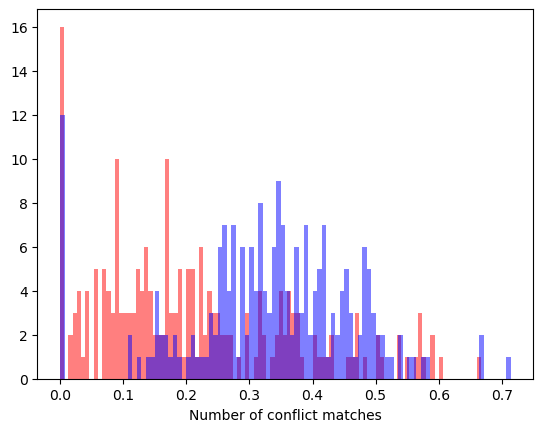

In [43]:
def conflicts(matches, prop:bool):
    conflicts = []
    for idx, match in matches.iterrows():
        id1 = match["ID1"]
        id2 = match["ID2"]
        r1 = match["RecSes1"]
        r2 = match["RecSes2"]

        neuron1=matches.loc[(matches["ID1"]==id1) & (matches["RecSes1"]==r1),:]
        if len(neuron1)>1:
            conflicts.append((r1,id1,r2,id2))
        
        neuron2=matches.loc[(matches["ID2"]==id2) & (matches["RecSes2"]==r2),:]
        if len(neuron2)>1:
            conflicts.append((r1,id1,r2,id2))
    if not prop:
        return len(set(conflicts))
    else:
        return len(set(conflicts))/len(matches)

mt = pd.read_csv(mt_path)
sessions = set(mt["RecSes1"].unique())

conflict_matches_dnn = []
conflict_matches_um = []
for r1 in sessions:
    for r2 in sessions:
        if r1>=r2:
            continue
        dnn_matches, um_matches = get_matches(mt, mt_path, r1, r2)
        conflict_matches_dnn.append(conflicts(dnn_matches, prop=True))
        conflict_matches_um.append(conflicts(um_matches, prop=True))
plt.hist(conflict_matches_dnn, bins = 100, label="DNN", color="r", alpha=0.5)
plt.hist(conflict_matches_um, bins = 100, label="UM", color="b", alpha=0.5)
plt.xlabel("Number of conflict matches")
plt.show()

In [7]:
# TESTING DIRECTIONAL FILTER
print(len(dnn_matches))
filtered = isi_corr.directional_filter(dnn_matches)
print(len(filtered))

for idx, row in filtered.iterrows():
    i1 = row["ID1"]
    i2 = row["ID2"]
    r1 = row["RecSes1"]
    r2 = row["RecSes2"]
    f = filtered.loc[
            (filtered["RecSes1"] == r2) & (filtered["ID1"] == i2) & 
            (filtered["RecSes2"] == r1) & (filtered["ID2"] == i1)
        ]
    if f.empty:
        print("MUNDO problemo")

128
104


In [12]:
# COUNTING SPLIT UNITS

test_data_root = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "R_DATA_UnitMatch")
mt_path = os.path.join(test_data_root, "AL036", "19011116882", "3", "new_matchtable.csv")
# mt_path = os.path.join(test_data_root, "AL032", "19011111882", "2", "new_matchtable.csv")
# mt_path = os.path.join(test_data_root, "AL031", "19011116684", "1", "new_matchtable.csv")
mt = pd.read_csv(mt_path)
within = mt.loc[(mt["RecSes1"]==mt["RecSes2"]), ["DNNSim", "ISICorr", "ID1", "ID2", "MatchProb", "RecSes1", "RecSes2"]]
across = mt.loc[(mt["RecSes1"]!=mt["RecSes2"]), ["DNNSim", "ISICorr", "MatchProb", "RecSes1", "RecSes2", "ID1", "ID2"]]
thresh = dnn_dist.get_threshold(mt, metric="DNNSim", vis=False)
diff = np.median(within["DNNSim"]) - np.median(across["DNNSim"])
thresh = thresh - diff
split_units, without = isi_corr.remove_split_units(mt_path, within, thresh)

In [13]:
split_units

4.313000616142945

In [5]:
# REPRODUCING EXTENDED DATA FIG 5
test_data_root = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "R_DATA_UnitMatch")
mt_path = os.path.join(test_data_root, "AL036", "19011116882", "3", "new_matchtable.csv")

mt = pd.read_csv(mt_path)
sessions = set(mt["RecSes1"].unique())
dnn_auc, um_auc, day1_d, day1_u, day2_d, day2_u, numbers_d, numbers_u = [], [], [], [], [], [], [], []
exp_ids,_ = mtpath_to_expids(mt_path, mt)
for r1 in tqdm(sessions):
    for r2 in tqdm(sessions):
        if r1>=r2:
            continue
        dnn, um, n_dnn, n_um = isi_corr.auc_one_pair(mt, r1, r2, mt_path=mt_path, dist_thresh=20)
        date1 = exp_id_to_date(exp_ids[r1])
        date2 = exp_id_to_date(exp_ids[r2])
        if dnn is not None:
            dnn_auc.append(dnn)
            day1_d.append(date1)
            day2_d.append(date2)
            numbers_d.append(n_dnn)
        if um is not None:
            um_auc.append(um)
            day1_u.append(date1)
            day2_u.append(date2)
            numbers_u.append(n_um)


100%|██████████| 21/21 [18:42<00:00, 53.45s/it]


In [20]:
dnn = pd.DataFrame({"DNN_day1": pd.to_datetime(day1_d), "DNN_day2": pd.to_datetime(day2_d), "DNNauc": dnn_auc, "DNN_n":numbers_d})
um = pd.DataFrame({"UM_day1": pd.to_datetime(day1_u), "UM_day2":pd.to_datetime(day2_u), "UMauc": um_auc, "UM_n": numbers_u})

day0_dnn = min(min(dnn['DNN_day1']), min(dnn['DNN_day2']))
day0_um = min(min(um['UM_day1']), min(um['UM_day2']))
dnn['DNN_day1'] = (dnn['DNN_day1'] - day0_dnn).dt.days
dnn['DNN_day2'] = (dnn['DNN_day2'] - day0_dnn).dt.days
um['UM_day1'] = (um['UM_day1'] - day0_um).dt.days
um['UM_day2'] = (um['UM_day2'] - day0_um).dt.days

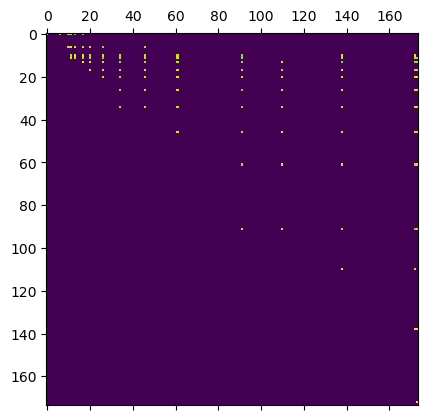

In [32]:
output = np.empty((174,174))

for idx, row in dnn.iterrows():
    i = int(row["DNN_day1"])
    j = int(row["DNN_day2"])

    output[i,j] = row["DNNauc"]

plt.matshow(output)

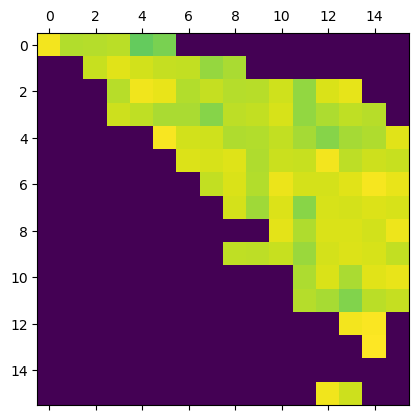

In [39]:
days = max(len(dnn["DNN_day1"].unique()), len(dnn["DNN_day2"].unique()))
if len(dnn["DNN_day1"].unique()) >= len(dnn["DNN_day2"].unique()):
    days = dnn["DNN_day1"].unique()
else:
    days = dnn["DNN_day2"].unique()
output = np.empty((len(days), len(days)))

for idx, row in dnn.iterrows():
    i = np.where(days==row["DNN_day1"])
    j = np.where(days==row["DNN_day2"])
    output[i,j] = row["DNNauc"]

plt.matshow(output)